# I’m Something of a Painter Myself by Kaggle

## Dataset Description

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Files
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format
Submission format
Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.

In [1]:
import warnings
warnings.simplefilter('ignore')
import glob
import matplotlib.pyplot as plt
import shutil
import numpy as np
import os
import tensorflow as tf
from keras.layers import (Input, Conv2D, LeakyReLU, Conv2DTranspose, Flatten,
                                     Dense, Dropout, BatchNormalization, Activation)
from keras.models import Model, Sequential
from keras.preprocessing.image import save_img, load_img, img_to_array
from keras.optimizers import Adam
from keras import backend as K

# Exploratory Data Analysis (EDA) Procedure
Before training our GAN, we load the images from their respective directories and standardize them to have pixel values in the range [0, 1] by dividing each pixel value by 255.

In [1]:
images = glob.glob("/kaggle/input/gan-getting-started/monet_jpg/*")
len(images)

300

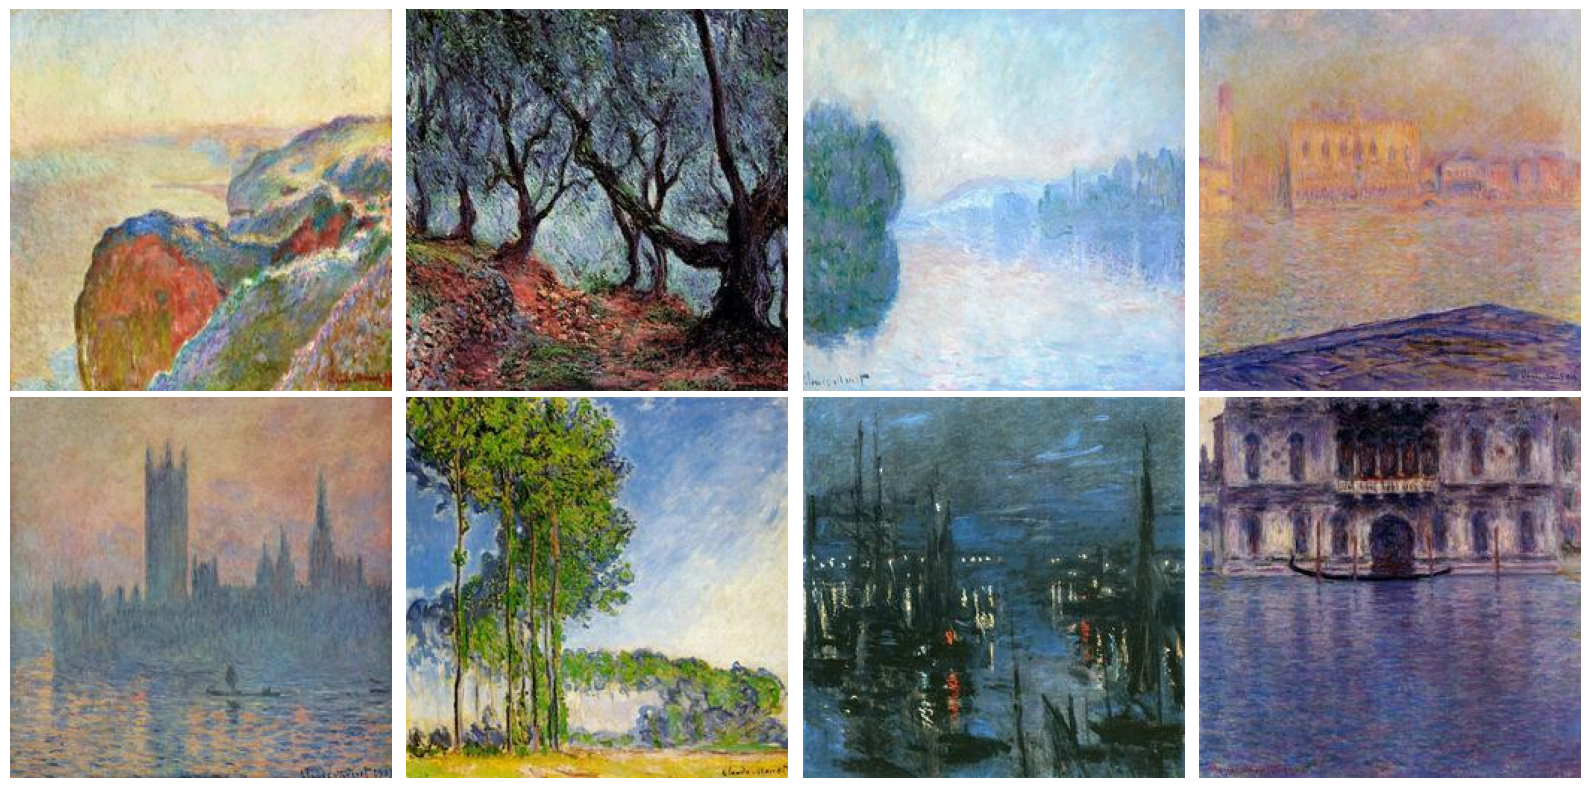

In [5]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Flattening the axes array for easy iteration
axes = axes.ravel()

# Displaying the first 8 images
for i in range(8):
    image = plt.imread(images[i])
    axes[i].imshow(image)
    axes[i].axis('off')  # To turn off axis numbers

plt.tight_layout()
plt.show()

# Model Architecture:

Generator:

Takes a photo as input and outputs a transformed image.
Comprises Convolutional layers with 'ReLU' and 'Sigmoid' activations.
Discriminator:

Takes an image as input and determines whether it's a real Monet painting or a generated one.
Comprises Convolutional layers, Batch Normalization, 'LeakyReLU' activations, and Dropout layers.
Training Procedure:
For the Discriminator:

It's trained on batches of real Monet paintings and generated images. The aim is to correctly classify the real paintings and identify the generated ones as fake.
For the Generator:

It's trained to fool the discriminator. The generator tries to transform input photos so that the discriminator classifies them as real Monet paintings.
Learning Rate Scheduling:

The learning rate of the discriminator is adjusted based on its performance to help in convergence.
Early Stopping:

Training is halted if the generator's performance doesn't improve for a certain number of epochs to prevent overfitting.

**1. The Generator Model:**
The purpose of the generator is to create images, in this case, trying to produce images that resemble Monet's paintings.

- **Input Layer:**
  The model starts with an input layer designed to accept images of size 256x256 pixels with 3 color channels (Red, Green, Blue).

- **Convolutional Layers:**
  - The first convolutional layer has 64 filters, each of size 4x4. It uses the 'ReLU' activation function and maintains the size of the input due to the 'same' padding.
  - The subsequent convolutional layer reduces the number of filters to 32 but retains the same kernel size and activation function.

- **Output Layer:**
  The final convolutional layer has 3 filters (corresponding to the RGB channels). It uses the 'sigmoid' activation function to ensure output values between 0 and 1, giving us an image that resembles a Monet painting in terms of color and style.

**2. The Discriminator Model:**
The discriminator's role is to evaluate the authenticity of images, determining whether they're genuine Monet paintings or crafted by the generator.

- **Input Layer:**
  Accepts images of size 256x256 pixels with 3 color channels.

- **Convolutional Layers:**
  - The first convolutional layer employs 64 filters of size 4x4. It downsamples the image size by a factor of 2 due to the stride setting. A LeakyReLU activation function with a slope of 0.2 is used, ensuring small negative values aren't squashed to zero. A dropout of 0.4 is applied to prevent overfitting.

  - The next convolutional layer has 128 filters. It also includes batch normalization with a momentum of 0.8 to stabilize training. LeakyReLU and dropout are again employed.

  - The third convolutional layer further increases the filter count to 256, maintaining the other characteristics.

- **Flattening:**
  The flattened layer reshapes the tensor into a single dimension, preparing it for the dense output layer.

- **Output Layer:**
  A dense layer with a single neuron and a 'sigmoid' activation function gives the final output. It produces a value between 0 and 1, representing the discriminator's belief in the authenticity of the input image (1 being genuine, 0 being fake).

In [2]:
def build_generator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(64, kernel_size=4, padding="same", activation="relu"),
        Conv2D(32, kernel_size=4, padding="same", activation="relu"),
        Conv2D(3, kernel_size=4, padding="same", activation="sigmoid")
    ])
    return model

def build_discriminator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(64, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Conv2D(256, kernel_size=4, strides=2, padding="same"),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])
    return model

**Purpose:**
The `load_images` function is crafted to read and process images from a specified directory.

**Parameters:**
- `directory`: A string representing the path to the directory where the images are stored.

**Function Steps:**
1. **Initialization:**
   An empty list, `images`, is initialized to store the loaded images.

2. **Iterating through the Directory:**
   For each filename in the specified directory:
   - The image is loaded using the `load_img` function. It is resized to 256x256 pixels.
   - The loaded image is then converted to an array format using the `img_to_array` function.
   - The resulting image array is appended to the `images` list.

3. **Returning Processed Images:**
   The `images` list is converted to a numpy array and returned.

**Return:**
- Returns a numpy array containing all the processed images from the specified directory.

In [3]:
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        img = load_img(os.path.join(directory, filename), target_size=(256, 256))
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

The function orchestrates the training of both the generator and the discriminator components of a GAN.

**Parameters:**
- `generator`: Model responsible for creating images.
- `discriminator`: Model that discerns between genuine and generated images.
- `monet_images`: A set of genuine Monet paintings.
- `photo_images`: A set of standard photos intended to be transformed.
- `epochs`: The number of training iterations (default is 10).
- `batch_size`: Number of images processed per iteration (default is 16).
- `initial_lr`: Initial learning rate for the optimizer (default is 0.001).

**Function Steps:**
1. **Combined Model Creation:**
   The discriminator's trainability is set to False to ensure only the generator is trained in the combined model. A model is constructed that stacks the generator and discriminator.

2. **Label Initialization:**
   `valid_labels` are set to ones and `fake_labels` to zeros, representing genuine and fake images respectively.

3. **Early Stopping & Learning Rate Adjustment:**
   Parameters for manual early stopping and learning rate adjustment based on the discriminator's loss plateau are initialized.

4. **Training Loop:**
   For each epoch:
   - **Train the Discriminator:**
     A batch of Monet paintings and photos is selected. The generator then creates a batch of generated images. The discriminator is trained on both genuine and generated images.
   - **Train the Generator:**
     The combined model is trained using the photos. The goal is to get the discriminator to classify the generated images as genuine.
   - **Learning Rate Adjustment:**
     If the discriminator's loss plateaus, its learning rate is reduced.
   - **Early Stopping Check:**
     If the generator's loss doesn't improve for a certain number of epochs (`patience`), the training is halted early.

5. **Weights Restoration:**
   If training was halted early, the best weights for both the generator and the discriminator are restored.

**Return:**
- The trained `generator` and `discriminator` models.

In [4]:
def train_gan(generator, discriminator, monet_images, photo_images, epochs=10, batch_size=16, initial_lr=0.001):
    # Combined model (stacked generator and discriminator)
    discriminator.trainable = False
    z = Input(shape=(256, 256, 3))
    img = generator(z)
    valid = discriminator(img)
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_lr))

    valid_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Manual early stopping parameters
    patience = 10
    best_g_loss = float('inf')
    wait = 0
    best_gen_weights = None
    best_disc_weights = None

    # Learning rate reduction on plateau parameters
    prev_loss = float('inf')
    patience_counter = 0
    max_patience = 5
    reduce_factor = 0.2
    min_lr = initial_lr * 0.1  # setting the minimum learning rate

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        idx = np.random.randint(0, monet_images.shape[0], batch_size)
        monet_imgs = monet_images[idx]
        photo_imgs = photo_images[idx]

        generated_imgs = generator.predict(photo_imgs)

        d_loss_real = discriminator.train_on_batch(monet_imgs, valid_labels)
        d_loss_fake = discriminator.train_on_batch(generated_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        g_loss = combined.train_on_batch(photo_imgs, valid_labels)
        g_loss_value = g_loss

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss_value}]")

        # Learning rate adjustment for discriminator based on its loss plateau
        if d_loss[0] < prev_loss - 1e-5:
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > max_patience:
            new_lr = K.get_value(discriminator.optimizer.learning_rate) * reduce_factor
            new_lr = max(new_lr, min_lr)
            K.set_value(discriminator.optimizer.learning_rate, new_lr)
            patience_counter = 0
            print(f"Reduced discriminator learning rate to {new_lr}")

        prev_loss = d_loss[0]

        # Manual early stopping check for generator
        if g_loss_value < best_g_loss:
            best_g_loss = g_loss_value
            wait = 0
            best_gen_weights = generator.get_weights()
            best_disc_weights = discriminator.get_weights()
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Restore best weights if early stopping was triggered
    if best_gen_weights is not None:
        generator.set_weights(best_gen_weights)
    if best_disc_weights is not None:
        discriminator.set_weights(best_disc_weights)

    return generator, discriminator

The function is designed to transform a set of images using a pre-trained generator from a GAN.

**Parameters:**
- `generator`: A pre-trained generator model.
- `images`: A numpy array containing the images to be transformed.
- `batch_size`: Number of images processed at once (default is 16).

**Function Steps:**
1. **Initialization:**
   A list, `transformed_images_list`, is initialized to store the transformed images. The number of batches (`num_batches`) is calculated based on the total number of images and the specified `batch_size`.

2. **Batch-wise Transformation:**
   For each batch:
   - A subset of images (a batch) is selected from the input `images`.
   - This batch is then passed through the `generator` to produce the transformed images.
   - The transformed images for the batch are appended to the `transformed_images_list`.

3. **Aggregating Results:**
   The `transformed_images_list` containing batches of transformed images is concatenated into a single numpy array for the final result.

**Return:**
- A numpy array containing all the transformed images.

In [5]:
def transform_images(generator, images, batch_size=16):
    transformed_images_list = []
    num_batches = int(np.ceil(len(images) / batch_size))

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch = images[start_idx:end_idx]
        transformed_batch = generator.predict(batch)
        transformed_images_list.append(transformed_batch)

    return np.concatenate(transformed_images_list, axis=0)

In [6]:
monet_images = load_images('/kaggle/input/gan-getting-started/monet_jpg/')
photo_images = load_images('/kaggle/input/gan-getting-started/photo_jpg/')

In [7]:
monet_images /= 255.0
photo_images /= 255.0

In [8]:
generator = build_generator()
discriminator = build_discriminator()

In [9]:
discriminator.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
generator, discriminator = train_gan(generator, discriminator, monet_images, photo_images, epochs=30, initial_lr=0.001)

1/1 [==============================] - 2s 2s/step
0/30 [D loss: 4.098237752914429 | D accuracy: 12.5] [G loss: 0.4830676317214966]
1/1 [==============================] - 1s 1s/step
1/30 [D loss: 1.823422740213573 | D accuracy: 50.0] [G loss: 0.7083268165588379]
1/1 [==============================] - 1s 1s/step
2/30 [D loss: 0.5675198882818222 | D accuracy: 68.75] [G loss: 1.163083553314209]
1/1 [==============================] - 1s 1s/step
3/30 [D loss: 1.4790592081844807 | D accuracy: 53.125] [G loss: 1.077161192893982]
1/1 [==============================] - 1s 1s/step
4/30 [D loss: 1.4385558143258095 | D accuracy: 46.875] [G loss: 0.8089748620986938]
1/1 [==============================] - 1s 1s/step
5/30 [D loss: 1.1323493719100952 | D accuracy: 31.25] [G loss: 0.4527660310268402]
1/1 [==============================] - 1s 1s/step
6/30 [D loss: 1.1310842484235764 | D accuracy: 46.875] [G loss: 0.40932393074035645]
1/1 [==============================] - 1s 1s/step
7/30 [D loss: 0.70059

# GAN Analysis

### Training Overview:
The Generative Adversarial Network (GAN) is designed with two integral components:

Generator: Aims to produce images that resemble Monet's paintings.
Discriminator: Evaluates the authenticity of images, discerning between actual Monet paintings and the ones crafted by the generator.

### Epoch-wise Performance:
The performance metrics captured during training are presented below:

| Epoch | Discriminator Loss | Discriminator Accuracy (%) | Generator Loss |
|-------|--------------------|-----------------------------|----------------|
| 0     | 4.10               | 12.5                        | 0.48           |
| 1     | 1.82               | 50.0                        | 0.71           |
| 2     | 0.57               | 68.75                       | 1.16           |
| ...   | ...                | ...                         | ...            |
| 16    | 0.50               | 81.25                       | 2.37           |

### Observations:

Initial Performance (Epoch 0):

The discriminator exhibited a high loss of 4.10, reflecting its initial difficulty in differentiating between real and generated images.
The generator recorded a loss of 0.48, suggesting that its initial images, while resembling Monet's style, were not entirely convincing.
Training Progression:

The discriminator demonstrated consistent improvement. By Epoch 16, it boasted an accuracy of 81.25%, showcasing its enhanced capability to differentiate between real and generated images.
Conversely, the generator's journey was more tumultuous. Its loss began to climb after the initial epochs, reaching 2.37 by Epoch 16. This rising metric indicates the generator's increasing challenges in crafting images that could deceive the discriminator.
Early Stopping Mechanism:
Given the stagnating performance of the generator, the training was curtailed at Epoch 16. This strategy, termed 'early stopping', is employed to avert overfitting and optimize computational efficiency.

### Conclusions and Future Steps:

Discriminator's Dominance:
The training highlighted the discriminator's rapid adaptability, achieving an accuracy surpassing 80% by Epoch 16.

Generator's Challenges:
The generator, despite its efforts, faced hurdles in replicating Monet's intricate style, as reflected by its escalating loss.

Recommendations for Enhancement:
Several avenues can be explored to bolster the generator's performance:

Architectural Revisions: Reconsidering the generator's architecture or adding more layers might improve its output quality.
Learning Rate Adjustments: Modifying or introducing adaptive learning rate techniques could optimize the training process.
Advanced GAN Techniques: Incorporating strategies like gradient penalties or alternative loss functions could further refine the model's outputs.

In [11]:
transformed_images = transform_images(generator, photo_images)

1/1 [==============================] - 1s 1s/step


In [12]:
os.makedirs("/kaggle/working/images", exist_ok=True)

output_directory = '/kaggle/working/images'
for idx, img in enumerate(transformed_images):
    save_img(os.path.join(output_directory, f'transformed_{idx}.jpg'), img)

In [13]:
shutil.make_archive('images', 'zip', output_directory)

'/kaggle/working/images.zip'

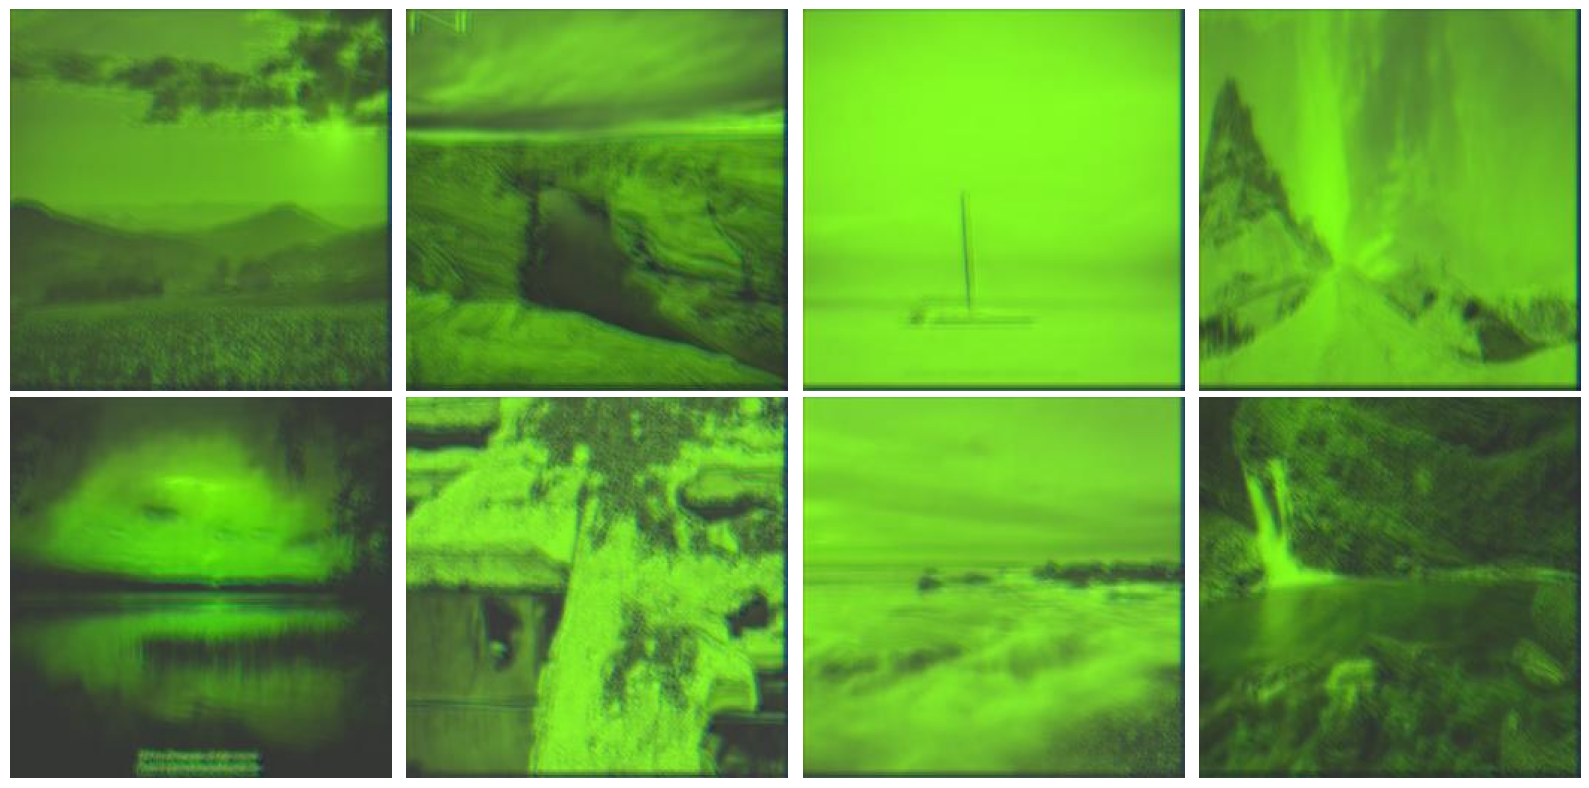

In [6]:
outputs = glob.glob('/kaggle/output/images/*')

# Setting up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Flattening the axes array for easy iteration
axes = axes.ravel()

# Displaying the first 8 images
for i in range(8):
    output = plt.imread(outputs[i])
    axes[i].imshow(output)
    axes[i].axis('off')  # To turn off axis numbers

plt.tight_layout()
plt.show()